In [1]:
# import packages
from gru import example_printer
from gru.dataset import GRUDataset_v2
from gru.gru_v2 import EncoderNet, DecoderNet, EncoderDecoder
from gru.cce import CCE, ConsciousCrossEntropy
import torch
import wandb
import pandas as pd
from selfies_tools import SELFIESVectorizer, determine_alphabet
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# weights and biases
!wandb login

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


# Data prep

In [4]:
alphabet = ['[#Branch1]',
 '[#Branch2]',
 '[#C]',
 '[#N]',
 '[/C]',
 '[/N]',
 '[/O]',
 '[=Branch1]',
 '[=Branch2]',
 '[=C]',
 '[=N+1]',
 '[=N]',
 '[=O]',
 '[=Ring1]',
 '[=Ring2]',
 '[=S]',
 '[Br]',
 '[Branch1]',
 '[Branch2]',
 '[C@@H1]',
 '[C@@]',
 '[C@H1]',
 '[C@]',
 '[C]',
 '[Cl]',
 '[F]',
 '[I]',
 '[N+1]',
 '[NH1]',
 '[N]',
 '[O-1]',
 '[O]',
 '[P]',
 '[Ring1]',
 '[Ring2]',
 '[S]',
 '[\\C]',
 '[\\N]',
 '[\\O]',
 '[end]',
 '[nop]',
 '[start]']

In [5]:
data_path = './GRU_data/Combined.parquet'
vectorizer = SELFIESVectorizer(alphabet)

dataset = GRUDataset_v2(data_path, vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 402863
Train size: 362576
Test size: 40287


In [6]:
from torch.utils.data import DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# NN architecture

In [7]:
# Set hyperparameters
encoding_size = 256
hidden_size = 256
num_layers = 1
learn_rate = 0.0002
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Training loop

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, train_loader, test_loader, vectorizer, device):

    EPOCHS = 20

    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss']);
    metrics['epoch'] = epochs_range
    
    # Init example printer
    printer = example_printer.ExamplePrinter(test_loader, num_examples=5)

    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display(fig, display_id=True)

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = CCE()

    # wandb config and init
    config = dict()
    config['learning rate'] = learn_rate
    config['encoding size'] = model.encoding_size
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num epochs'] = EPOCHS
    config['Trainable parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    config['hidden size'] = model.hidden_size
    config['Number of layers'] = num_layers
    config['Dropout'] = model.decoder.dropout
    config['Batch size'] = batch_size
    config['teacher_ratio'] = teacher_ratio
    wandb.init(project="encoded-token-concat", config=config)

    print("Starting Training of GRU")
    print(f"Device: {device}")
    
    samples = []
    
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0
        model.train()
        for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X, y, teacher_forcing=True).to(device)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # calculate loss and log to wandb
        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, test_loader)
        metrics_dict = {'epoch': epoch,
                        'train_loss': avg_loss,
                        'val_loss': val_loss}
        wandb.log(metrics_dict)

        # Update metrics df
        metrics.loc[len(metrics)] = metrics_dict

        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
        
        new_samples = printer(model)
        samples.append(new_samples)
        
    plt.close()
    wandb.finish()
    return model, samples

def evaluate(model, test_loader):
    model.eval()
    criterion = ConsciousCrossEntropy()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X, y, teacher_forcing=False).to(device)
        loss = criterion(y, output)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(test_loader)
    return avg_loss

# Train the model

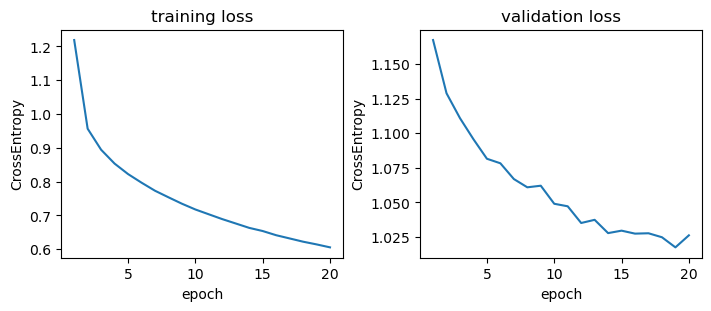

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


Starting Training of GRU
Device: cuda
Epoch: 1


100%|███████████████████████████████████████| 1416/1416 [17:02<00:00,  1.38it/s]


Predicted SELFIE:
[C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1

100%|███████████████████████████████████████| 1416/1416 [17:51<00:00,  1.32it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
---------

100%|███████████████████████████████████████| 1416/1416 [17:17<00:00,  1.37it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Bra

100%|███████████████████████████████████████| 1416/1416 [17:21<00:00,  1.36it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Ring2][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
-----------------

100%|███████████████████████████████████████| 1416/1416 [17:12<00:00,  1.37it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Ring2][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1]

100%|███████████████████████████████████████| 1416/1416 [16:40<00:00,  1.42it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
--------

100%|███████████████████████████████████████| 1416/1416 [16:32<00:00,  1.43it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][=C][=C][=C][=C][=C][=C][=C][=C][=C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
-------

100%|███████████████████████████████████████| 1416/1416 [16:49<00:00,  1.40it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][Branch1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------------------------------------------

100%|███████████████████████████████████████| 1416/1416 [16:32<00:00,  1.43it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
-------------------------------

100%|███████████████████████████████████████| 1416/1416 [16:14<00:00,  1.45it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][N][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][C][C][=C][Branch1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=O][=O][=O][=O] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------------------

100%|███████████████████████████████████████| 1416/1416 [16:44<00:00,  1.41it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][=C][C][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------------------------------------

100%|███████████████████████████████████████| 1416/1416 [16:32<00:00,  1.43it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][Ring1][Ring1][C][C][=C][=C][Ring1][C][C][C][C][Ring1][Ring1][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring2][O][C][=C][C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------------------

100%|███████████████████████████████████████| 1416/1416 [16:24<00:00,  1.44it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][=C][Ring1][C][C][C][C][=C][Branch1][Branch1][C][C][C][=C][Branch1][Branch1][C][C][=C][=C][Ring1][C][C][=C][=C][Ring1][Ring1][C][C][Ring1][Ring1][Ring1][Ring1][C][C][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring2][O][C][C][=C][Ring1][#Branch1][C][C][C][Branch1][C][C][C][C][C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=O][=O] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N]

100%|███████████████████████████████████████| 1416/1416 [19:37<00:00,  1.20it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][C][C][=C][=C][Ring1][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring2][O][C][C][C][Ring1][Ring1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------------------------

100%|███████████████████████████████████████| 1416/1416 [17:55<00:00,  1.32it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][=C][C][=C][C][C][C][C][C][=C][C][Branch1][C][C][C][=C][=C][Ring1][O][C][C][=C][Ring1][O][O][C][=C][Ring1][O][C][C][=C][Ring1][C][C][C][Ring2][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
-------------------------

100%|███████████████████████████████████████| 1416/1416 [16:29<00:00,  1.43it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][=C][C][Ring1][C][C][C][=C][C][Branch1][C][C][C][=C][Ring1][Ring1][O][C][=C][Ring1][Ring1][O][C][=C][=C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
--------------------------------

100%|███████████████████████████████████████| 1416/1416 [16:03<00:00,  1.47it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][=C][Ring1][C][C][C][C][C][C][Branch1][C][C][C][=C][C][Branch1][C][C][=C][=C][Ring1][O][O][C][=C][Ring1][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][#Branch1][C][C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------

100%|███████████████████████████████████████| 1416/1416 [15:52<00:00,  1.49it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][Branch1][Ring1][C][C][C][C][C][Branch1][C][O][C][=C][=C][Branch1][O][O][C][=C][Ring1][Ring1][O][C][=C][=C][Ring1][C][C][C][C][C][C][C][Ring2][Ring2][Ring2][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][C][C][C][=C][C][C][C][C][C][=C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]
----------------

100%|███████████████████████████████████████| 1416/1416 [15:21<00:00,  1.54it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][=C][C][Branch1][Ring1][C][C][C][C][C][Branch1][C][O][C][=C][Branch1][Branch1][O][C][C][=C][Ring1][O][O][C][=C][Ring1][O][O][C][=C][Ring1][Ring1][Ring1][Ring2][Ring2][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][#Branch1][C][O][C][C][C][C][C][C][C][=C][C][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][=C][=C][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O][C][=Ring1][O][N][=C][Ring2][Ring1][=N]


100%|███████████████████████████████████████| 1416/1416 [15:44<00:00,  1.50it/s]


Predicted SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][C][Branch1][Ring1][C][C][C][C][C][Branch1][C][O][C][=C][Branch1][Branch1][O][O][C][=C][Ring1][Ring1][O][C][=C][Branch1][Ring1][O][C][C][Branch1][Branch1][C][C][C][C][Ring2][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1] 

True SELFIE:
[C][C][O][C][=Branch1][C][=O][C][C][C][C][Branch1][C][C][=N][C][=C][C][Branch1][P][C][=C][C][Branch1][Ring1][O][C][=C][C][Branch1][Ring1][O][C][=C][Ring1][#Branch2][=N][N][Ring1][#C][C][=Ring2][Ring1][Ring2][O]
------------------------------------------------------------
Predicted SELFIE:
[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][#Branch1][C][C][C][Branch1][C][C][C][C][=C][Ring1][#Branch1][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1] 

True SELFIE:
[C][O][C][=C][C][=C][Branch2][Ring2][=Branch1][C@H1][C][C@@H1][Ring1][Ring1][C][O][C][=N][C][Branch1][C][C][=N][C][=C][Ring1][#Branch1][C][C][=C][N][Branch1][#Branch1][C][C][=Branch1][C][=O][O][C][=Branch1][C][=O]

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁
epoch,20
train_loss,0.60544
val_loss,1.02619


In [10]:
model, samples = train(model, train_loader, test_loader, vectorizer, device)

In [12]:
# save model
torch.save(model.state_dict(), './GRU_data/params/v2_w-teacher-0')